# Residual Networks !!!

> Why there is need of residual connection?

- As the depth of CNN model increases, the performance keeps getting better.(till the certain layers)

- Ex. VGG (18-layers) beats AlexNet (8-layers) performance.

- But after increasing more layers in VGG, it starts decreasing its performance.

- Residual connection helps in improving training for larger models.

- Without losing its performance even after increasing its depth.

- But using residual connection can cause an exponential increase in the magnitude of activation at initialization.

- To control and re-center the magnitude of activation, it uses batch-norm at each layer (residual block).

- **additional Note:** ResNets provide a direct path for the gradient, mitigating the problem of vanishing gradients, and allowing the network to train effectively even as it becomes deeper.

> Why model with more depth start decreasing its performance?

- So the model with no skip or residual connection is known as a sequential model.

- Ex. layer = l1, l2, l3, and l4 -> model_with_ln -> y =  (l4(l3(l2(l1(x))))) (forward pass in seq model looks like this, right?)

- suppose we started with the input data x and as data passes through the deep layers at the last layer it become the random noise.(as we are multi-applying the random weights to it)

- then we do backpass in order to get low loss by updating parameter.

- two problem rises :
  
  - one at the time of forward the input become random noise at last layer.
  - during the backprop the update doesn't make any sense cause it connected to the last layer.

- In a deep neural network, even a small change in input can cause a lot of change in its gradient. This is known as the shattered gradient phenomenon.

- The shattered gradient phenomenon causes the gradient to become increasingly complex and less smooth as it propagates through many layers.

- Due to this, the gradient descent algorithm (GDA) doesn't perform well because GDA needs a smooth gradient curve to perform well.

- Because the performance of GDA depends on before and after gradient (due to the chain rule).

- Check out the backprop file to understand this more.

> how to solve the above problem ?

- what we need to solve 
  
  - data that is passing through the layers should not pass random noise(should we have some meaning to it)
  - as we solve above problem the backpass will do the meaning update in same way above.

- can be solved using resnet.

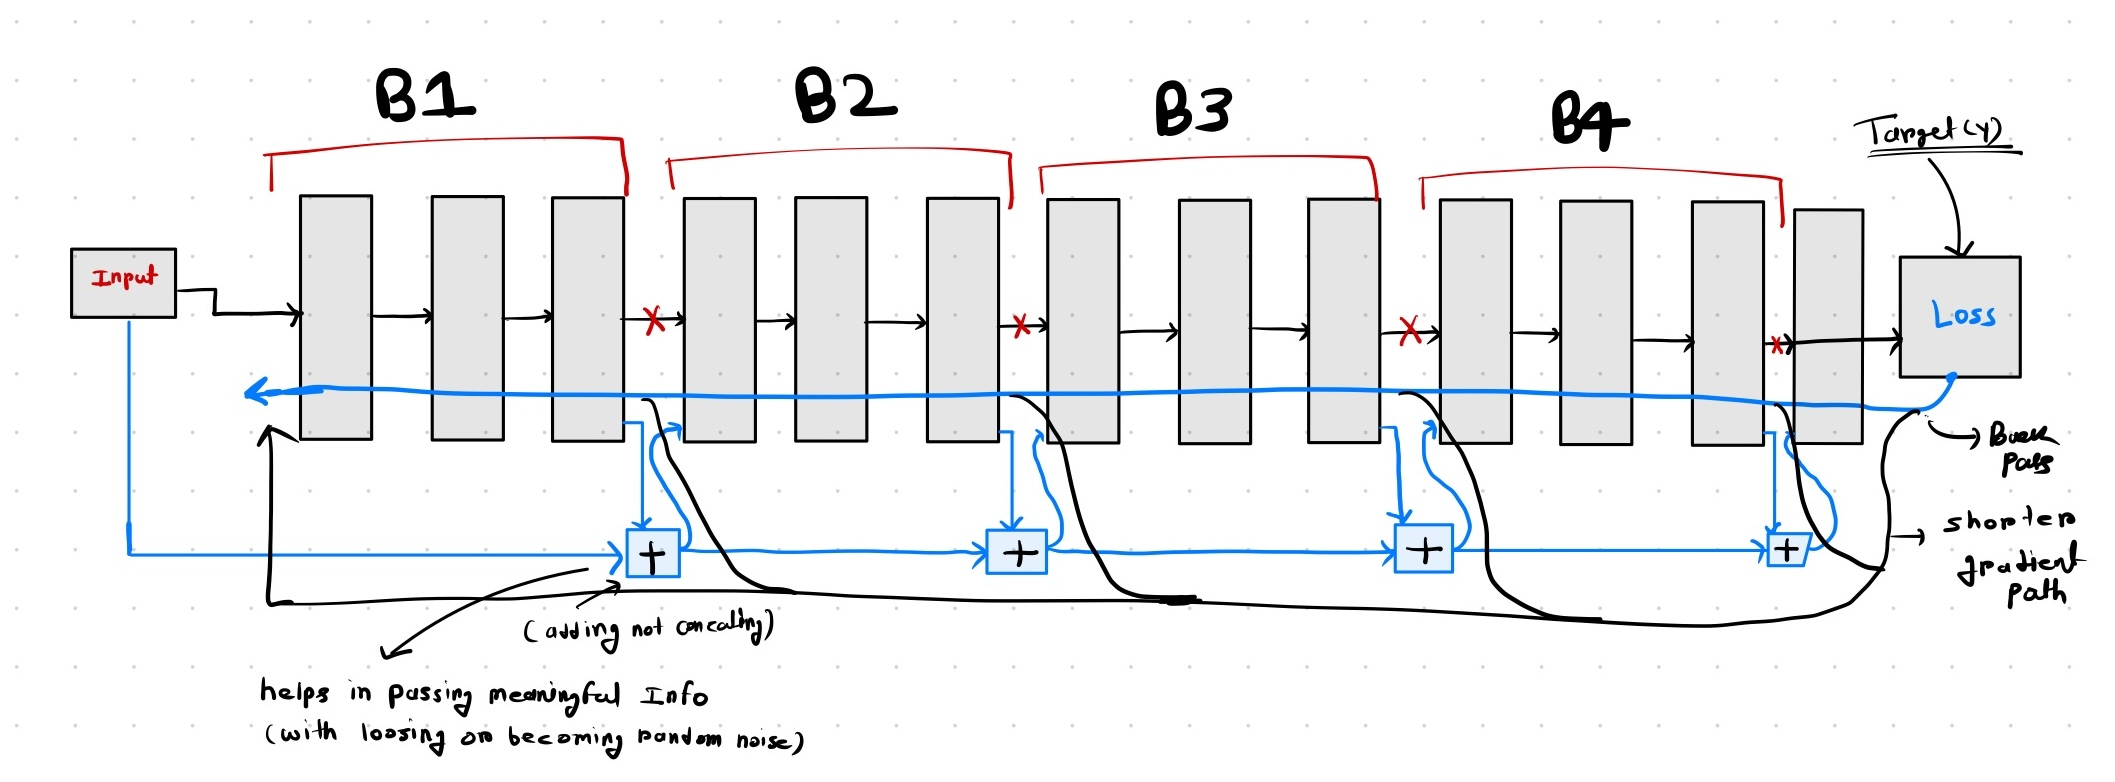

- We can add residuals followed by the linear transformation layer and activation function.

- In practice, we generally add it after several layers of the network.

- If we start res-block with ReLU, they will do nothing if input is zero (ReLU -> 0, neg).

- Hence, we add the res-block after the linear transformation to avoid being lazy for negative values.

- We cannot choose the depth of the network randomly even if it performs well because adding res-block will roughly double the depth of the network, which might affect the variance of activation during the forward pass, and as a result, cause gradient exploding for the backward pass.

- The main purpose of residual connections is to allow the network to learn identity functions easily, effectively skipping layers that are not beneficial.

> How to solve this variance problem that results in gradient exploding?

- In order to handle the exponential variance problem, we need to normalize the inputs.

- This can be solved with the help of batch-norm.

> What is batch-norm?

- To use the batch, we must provide the data in mini-batches to train.

- As its name goes, it uses a batch to calculate the mean and std.

- Mean and std are used as parameters to calculate batch-norm (these are running statistics, not learnable parameters).

- Batch norm is very effective because it not only normalizes but also, if the model doesn't need normalizing, it shifts and scales the input using gamma and beta (learnable parameters).

- **additional Note:** Batch normalization helps stabilize and accelerate the training process by normalizing the inputs of each layer. This is especially beneficial when combined with residual networks, further enhancing their ability to train deep architectures efficiently.

- For more on batch-norm, check the link.

> **Formula for ResNet:**

- A basic residual block can be represented as:

  \( y = F(x, \{W_i\}) + x \)

  where \( x \) is the input, \( F(x, \{W_i\}) \) represents the residual function (e.g., a stack of convolutional layers), and \( y \) is the output.

- The key idea is that instead of expecting each layer to directly learn a desired underlying mapping, it learns the residual mapping which is easier to optimize.

- This formulation allows the network to easily learn identity mappings by pushing the residual to zero, which helps in training very deep networks.

> additional Points from the Paper:

- **Residual Block Configuration:** Residual blocks can be constructed with multiple layers, not just one. Typically, each residual block consists of two or three convolutional layers, and batch normalization is applied before each nonlinearity.

- **Training Efficiency:** Residual networks, thanks to their architecture, are able to train much deeper networks without the problems of vanishing or exploding gradients. This results in more efficient training and better performance on deeper models.

- **Performance:** results show that residual networks achieve lower error rates on benchmarks such as ImageNet.(resutling sota model)

> uses 

- almost everywhere.(transformer, stable diffusions)
 

### time for code

> will coding resent-50

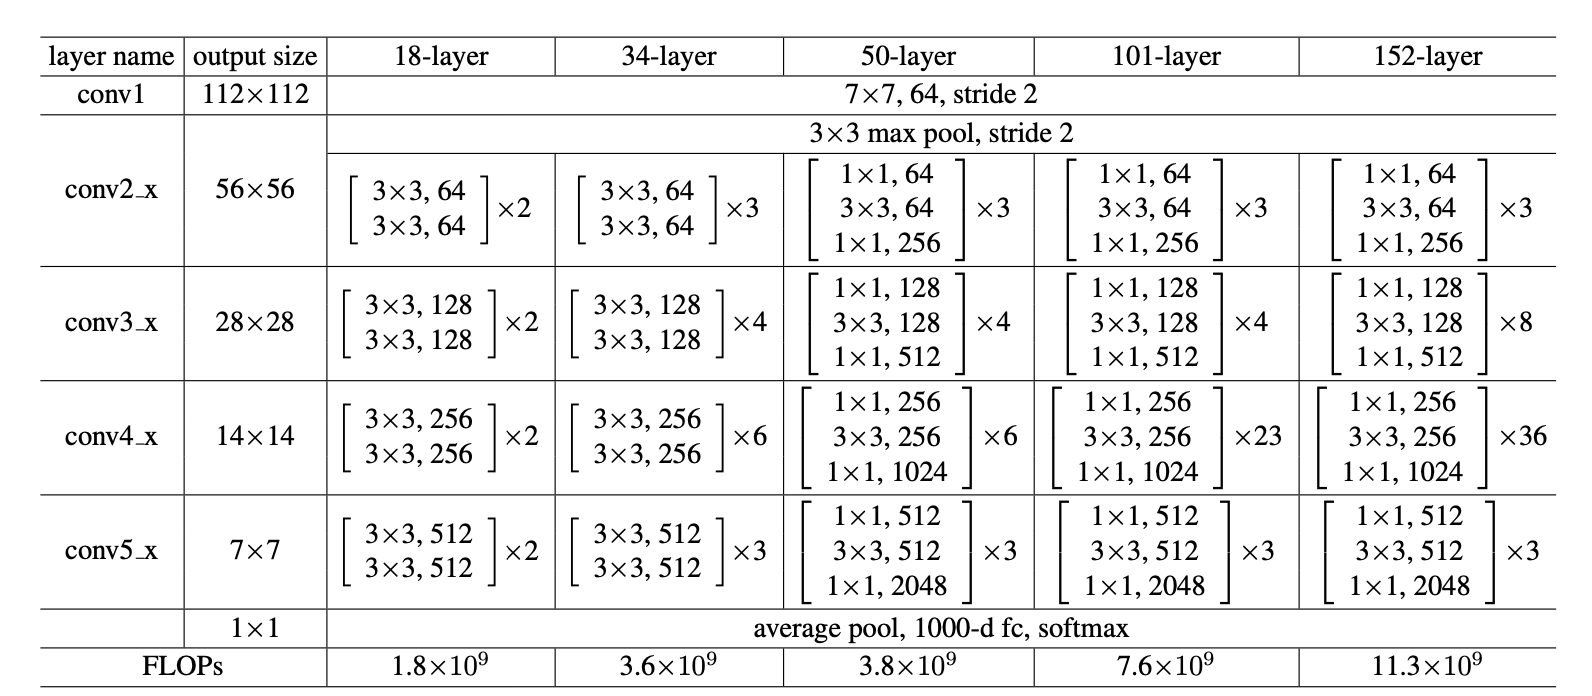

In [2]:
# import 
import torch 
from torch import nn 
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(device)


cuda


> the basiuc resnet block used to build the resnet-34 

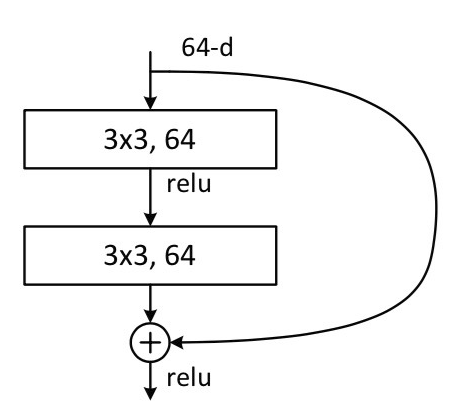

In [3]:
class ResBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        #print("Block input shape:", x.shape)
        
        x = self.relu(self.batch_norm1(self.conv1(x)))
        #print("After conv1 + BN + ReLU:", x.shape)
        
        x = self.batch_norm2(self.conv2(x))
        #print("After conv2 + BN:", x.shape)

        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
            #print("Identity after downsample:", identity.shape)
        
        x += identity
        x = self.relu(x)
        #print("Output of Block:", x.shape)
        
        return x



> the most used res-block that helps increasing the depth and also control the size of small.

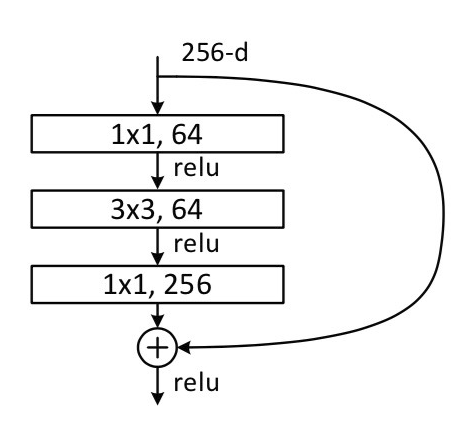

In [4]:
class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)
        
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)
        
        self.i_downsample = i_downsample
        self.relu = nn.ReLU()
        
    def forward(self, x):
        identity = x.clone()
        #print("Bottleneck input shape:", x.shape)
        
        x = self.relu(self.batch_norm1(self.conv1(x)))
        #print("After conv1 + BN + ReLU:", x.shape)
        
        x = self.relu(self.batch_norm2(self.conv2(x)))
        #print("After conv2 + BN + ReLU:", x.shape)
        
        x = self.batch_norm3(self.conv3(x))
        #print("After conv3 + BN:", x.shape)
        
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
            #print("Identity after downsample:", identity.shape)
        
        x += identity
        x = self.relu(x)
        #print("Output of Bottleneck:", x.shape)
        
        return x

In [5]:
# Arch-of-ResNet

class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64
        
        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        #print("input shape:", x.shape)
        
        x = self.relu(self.batch_norm1(self.conv1(x)))
        #print("after conv1 + BN + ReLU:", x.shape)
        
        x = self.max_pool(x)
        #print("after max pooling:", x.shape)

        x = self.layer1(x)
        #print("after layer1:", x.shape)
        
        x = self.layer2(x)
        #print("after layer2:", x.shape)
        
        x = self.layer3(x)
        #print("after layer3:", x.shape)
        
        x = self.layer4(x)
        #print("after layer4:", x.shape)
        
        x = self.avgpool(x)
        #print("after avgpool:", x.shape)
        
        x = x.view(x.size(0), -1)
        #print("after flatten:", x.shape)
        
        x = self.fc(x)
        #print("output shape:", x.shape)
        
        return x
        
    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        
        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )
            
        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion
        
        for _ in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
            
        return nn.Sequential(*layers)

def ResNet50(num_classes, channels=3):
    return ResNet(ResBlock, [3, 4, 6, 3], num_classes, channels)


In [8]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [9]:
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
net = ResNet50(10).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [13]:
EPOCHS = 200

for epoch in range(EPOCHS):
    running_loss = 0.0
    losses = []

    for i, (inputs, labels) in enumerate(trainloader):
        # Move inputs and labels to the GPU
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Record the loss
        running_loss += loss.item()
        losses.append(loss.item())

        # Print statistics every 100 mini-batches
        if (i + 1) % 100 == 0:
            print(f'Loss [{epoch + 1}, {i + 1}](epoch, minibatch): {running_loss / 100:.4f}')
            running_loss = 0.0

    # Calculate the average loss for the epoch
    avg_loss = sum(losses) / len(losses)

    # Step the learning rate scheduler
    scheduler.step(avg_loss)

    # Print average loss for the epoch
    print(f'Epoch [{epoch + 1}/{EPOCHS}], Average Loss: {avg_loss:.4f}')

print('Training Done')


Loss [1, 100](epoch, minibatch): 1.7524
Loss [1, 200](epoch, minibatch): 1.7081
Loss [1, 300](epoch, minibatch): 1.6713
Epoch [1/200], Average Loss: 1.6951
Loss [2, 100](epoch, minibatch): 1.6186
Loss [2, 200](epoch, minibatch): 1.6174
Loss [2, 300](epoch, minibatch): 1.5969
Epoch [2/200], Average Loss: 1.5997
Loss [3, 100](epoch, minibatch): 1.5285
Loss [3, 200](epoch, minibatch): 1.4987
Loss [3, 300](epoch, minibatch): 1.5023
Epoch [3/200], Average Loss: 1.4982
Loss [4, 100](epoch, minibatch): 1.4153
Loss [4, 200](epoch, minibatch): 1.4194
Loss [4, 300](epoch, minibatch): 1.4151
Epoch [4/200], Average Loss: 1.4077
Loss [5, 100](epoch, minibatch): 1.3527
Loss [5, 200](epoch, minibatch): 1.3284
Loss [5, 300](epoch, minibatch): 1.3013
Epoch [5/200], Average Loss: 1.3177
Loss [6, 100](epoch, minibatch): 1.2822
Loss [6, 200](epoch, minibatch): 1.2470
Loss [6, 300](epoch, minibatch): 1.2251
Epoch [6/200], Average Loss: 1.2444
Loss [7, 100](epoch, minibatch): 1.1855
Loss [7, 200](epoch, min

In [19]:

correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('accuracy on 10,000 test images: ', 100*(correct/total), '%')

accuracy on 10,000 test images:  85.04 %
